In [23]:
# Import necessary libraries and the encoder module
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import datasets
import pandas as pd
from tensorflow.keras.callbacks import CSVLogger

In [24]:
# Import from encoder.py
from encoder import tokenize_and_pad, EncoderBooleanTransformer

In [25]:
# Load IMDB dataset
imdb = datasets.load_dataset('imdb')

# Decide on the maximum number of words to keep
num_words=10000

In [26]:
# Tokenizer for IMDB dataset
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(imdb['train']['text'])

In [27]:
# Data preparation for Transformer model
max_length = 120
X_train_transformer = tokenize_and_pad(imdb['train']['text'], tokenizer, max_length)
y_train_transformer = np.array(imdb['train']['label'])
X_test_transformer = tokenize_and_pad(imdb['test']['text'], tokenizer, max_length)
y_test_transformer = np.array(imdb['test']['label'])

In [28]:
# Data preparation for traditional models
vectorizer = CountVectorizer(max_features=num_words)
X_train_traditional = vectorizer.fit_transform(imdb['train']['text'])
y_train_traditional = np.array(imdb['train']['label'])
X_test_traditional = vectorizer.transform(imdb['test']['text'])
y_test_traditional = np.array(imdb['test']['label'])

In [29]:
# SVM
svm_model = LinearSVC()
svm_model.fit(X_train_traditional, y_train_traditional)
y_pred_svm = svm_model.predict(X_test_traditional)
svm_accuracy = accuracy_score(y_test_traditional, y_pred_svm)
svm_precision = precision_score(y_test_traditional, y_pred_svm)
svm_recall = recall_score(y_test_traditional, y_pred_svm)
svm_f1 = f1_score(y_test_traditional, y_pred_svm)

c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


In [30]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_traditional, y_train_traditional)
y_pred_nb = nb_model.predict(X_test_traditional)
nb_accuracy = accuracy_score(y_test_traditional, y_pred_nb)
nb_precision = precision_score(y_test_traditional, y_pred_nb)
nb_recall = recall_score(y_test_traditional, y_pred_nb)
nb_f1 = f1_score(y_test_traditional, y_pred_nb)

In [31]:
# Hyperparameters for Transformer model
num_layers = 2
d_model = 256
num_heads = 8
dff = 512
input_vocab_size = num_words + 1

# Initialize and compile Transformer model
transformer_model = EncoderBooleanTransformer(num_layers, d_model, num_heads, dff, input_vocab_size, max_length)
optimizer = tf.keras.optimizers.Adam(0.0001)
transformer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train Transformer model
history = transformer_model.fit(
    X_train_transformer, 
    y_train_transformer, 
    batch_size=32, 
    epochs=4, 
    validation_data=(X_test_transformer, y_test_transformer), 
    callbacks=[CSVLogger('results/imdb_log_0.0001.csv')]
)

Epoch 1/4
782/782 [==============================] - 65s 79ms/step - loss: 0.4552 - accuracy: 0.7636 - val_loss: 0.3759 - val_accuracy: 0.8403
Epoch 2/4
782/782 [==============================] - 62s 80ms/step - loss: 0.2729 - accuracy: 0.8876 - val_loss: 0.3194 - val_accuracy: 0.8624
Epoch 3/4
782/782 [==============================] - 65s 83ms/step - loss: 0.2168 - accuracy: 0.9139 - val_loss: 0.3577 - val_accuracy: 0.8549
Epoch 4/4
782/782 [==============================] - 65s 83ms/step - loss: 0.1818 - accuracy: 0.9300 - val_loss: 0.4210 - val_accuracy: 0.8340


In [32]:
# Evaluate Transformer model
y_pred_transformer = (transformer_model.predict(X_test_transformer) > 0.5).astype("int32")
transformer_accuracy = accuracy_score(y_test_transformer, y_pred_transformer)
transformer_precision = precision_score(y_test_transformer, y_pred_transformer)
transformer_recall = recall_score(y_test_transformer, y_pred_transformer)
transformer_f1 = f1_score(y_test_transformer, y_pred_transformer)

782/782 [==============================] - 18s 22ms/step


In [33]:
# Output a df with the results
results = pd.DataFrame({
    'Model': ['SVM', 'Naive Bayes', 'Transformer'],
    'Accuracy': [svm_accuracy, nb_accuracy, transformer_accuracy],
    'Precision': [svm_precision, nb_precision, transformer_precision],
    'Recall': [svm_recall, nb_recall, transformer_recall],
    'F1': [svm_f1, nb_f1, transformer_f1]
})

# Save the results to a csv file
results.to_csv('results/imdb_results_0.0001.csv', index=False)

results

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.82868,0.837398,0.81576,0.826438
1,Naive Bayes,0.82088,0.855270,0.77248,0.811770
2,Transformer,0.83396,0.891788,0.76016,0.820730


c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/imdb_results_0.0001.png


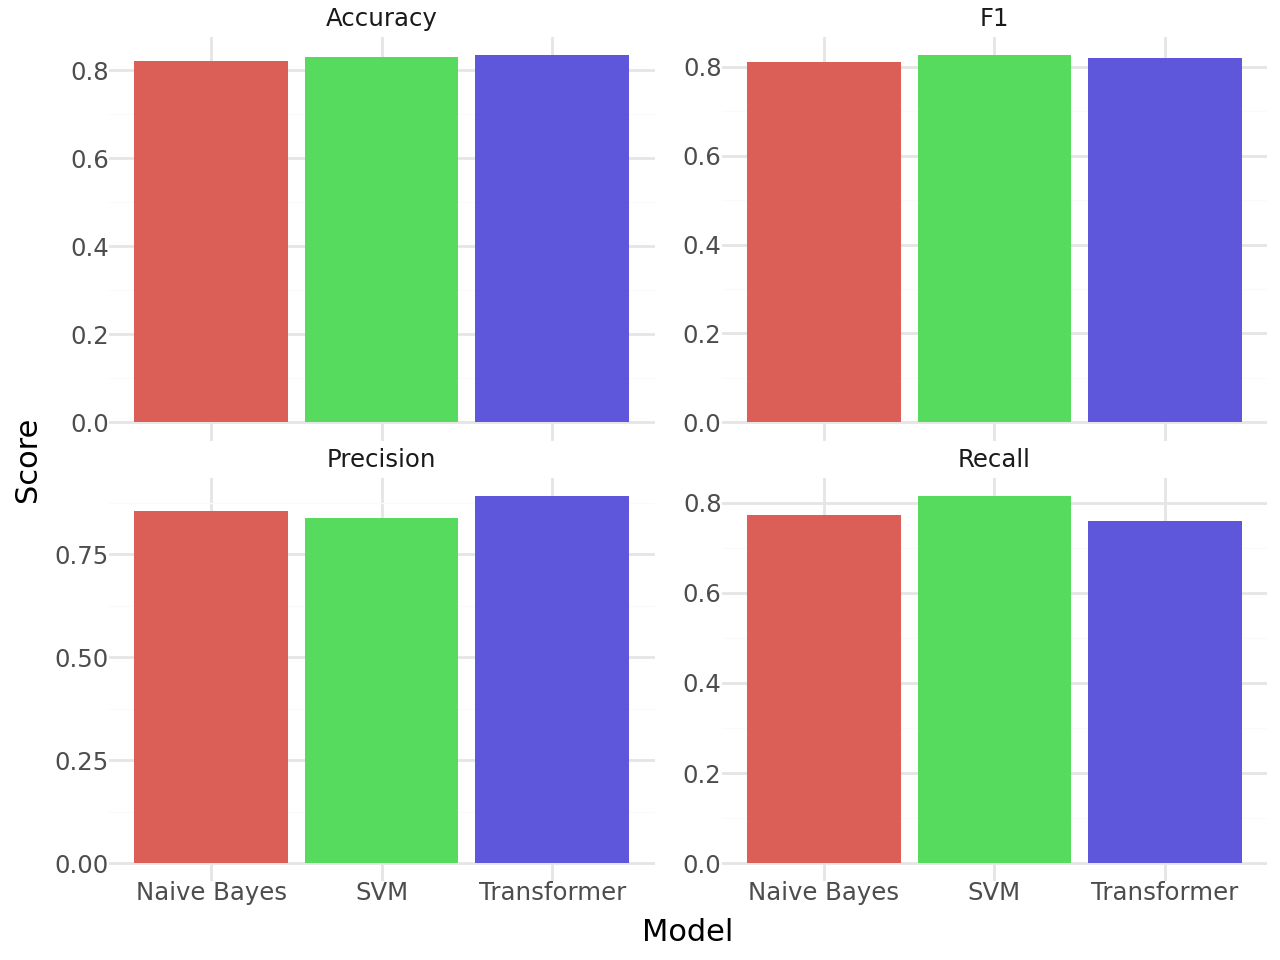

In [34]:
# output the results with plotnine
from plotnine import *

results_long = results.melt(id_vars='Model', var_name='Metric', value_name='Score')

p = (
    ggplot(results_long, aes(x='Model', y='Score', fill='Model')) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap('~Metric', scales='free_y') +
    theme_minimal() +
    theme(legend_position='none')
)

p.save('results/imdb_results_0.0001.png', width=10, height=5, dpi=300)

p

c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/imdb_history_0.0001.png


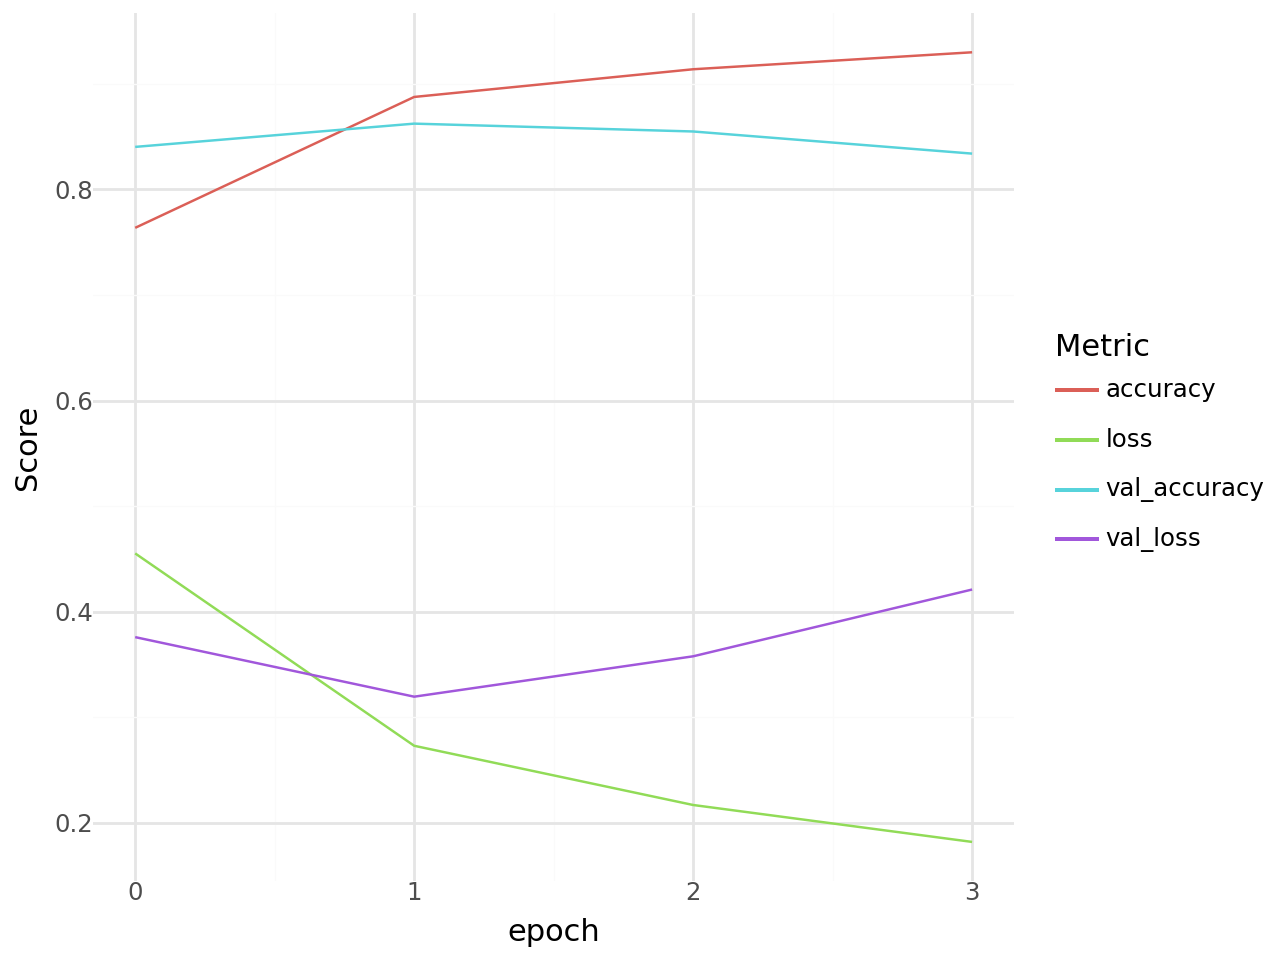

In [35]:
# plot the training history of the Transformer model
history_df = pd.read_csv('results/imdb_log_0.0001.csv')

history_df_long = history_df.melt(id_vars='epoch', var_name='Metric', value_name='Score')

p2 = (
    ggplot(history_df_long, aes(x='epoch', y='Score', color='Metric')) +
    geom_line() +
    theme_minimal()
)

p2.save('results/imdb_history_0.0001.png', width=10, height=5, dpi=300)

p2